<a href="https://colab.research.google.com/github/puspo1997/PreProcessing_Code/blob/master/1_gray_img_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras==2.1.5

In [2]:
!pip install tensorflow==1.14.0
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
cd /content/drive/MyDrive/New_folder

/content/drive/MyDrive/New_folder


In [4]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.image
import glob
import scipy.misc
from PIL import Image
#import imgaug 
from imgaug import augmenters as iaa

In [5]:
# Root directory of the project
ROOT_DIR = os.getcwd()
ROOT_DIR = ROOT_DIR+"/Mask_r_cnn"

MAMOGRAM_IMAGE_DIR = "/scans/preprocessed_image/" #Path of the mammograms
MAMOGRAM_MASK_DIR = "/scans/preprocessed_mask/"# Path of the ground truth masks


# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join("/content/drive/MyDrive/Mammographic", "logs")#Log directory for saving the weights
DEMO_SAVE_DIR = "/scans/seg_mask/"# path to save the segmentation masks


Using TensorFlow backend.


In [6]:
############################################################
#  Configurations
############################################################


class MamogramConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mamogram"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + lesion

    # Number of training steps per epoch,set to the number of training data here
    STEPS_PER_EPOCH = 3

    # Number of validation steps after each round of training
    VALIDATION_STEPS = 2
    # Resize mode: "none" or "square"

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Skip detections with < DETECTION_MIN_CONFIDENCE
    DETECTION_MIN_CONFIDENCE = 0.965 # alter this during testing to generate different TPR at different FPI
    # 0.7 0.75 0.8 0.85 0.9 

config = MamogramConfig()
#config.display()

In [7]:
############################################################
#  Dataset
############################################################

class MamogramDataset(utils.Dataset):

    
    def load_mamogram(self, subset):
        """This method loads the actual image
        subset is either "train" or "val" depending on whether the image is part of the training or validation datasets 
        """
        # Add classes. We have only one class to add.
        # These are the things that will be segmented
        self.add_class("mamogram", 1, "lesion")

        # Train or validation dataset?

        #list all the files in the directory with the mamogram images
        files = os.listdir(ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset + "/")
        
        for fname in files:            
            self.add_image("mamogram", image_id=fname, 
                           path=ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset +"/"+ fname, subset=subset, fname=fname)

    
    def load_mask(self, image_id):
        """load the instance masks for an image.
        Returns:
        a tuple containing:
        masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        use dtype=np.int32
        """
        image_info = self.image_info[image_id]
        info = self.image_info[image_id]
        fname = info['fname']
       
        files = glob.glob(ROOT_DIR + MAMOGRAM_MASK_DIR + info['subset']+"/" + fname[0:-4] + "*")
        

        masks = []
        for i in range(0, len(files)):
            #print(i)
            data = skimage.io.imread(files[i])
            #print(data)
            if data.ndim != 1:
                data = skimage.color.rgb2gray(data)
          
            singleMask = data
            if i == 0:
                masks = np.zeros((singleMask.shape[0], singleMask.shape[1], len(files)))
            masks[:,:,i] = singleMask
            print("mask Shape")
            print(masks.shape)

        instanceMaskMap = np.array(np.ones([masks.shape[-1]], dtype=np.int32))
        
        return (masks.astype(np.bool), instanceMaskMap)
        #class_ids = np.array([self.class_names.index(s[0]) for s in fname])
        #return mask.astype(np.bool), class_ids.astype(np.int32)
         #this is VERY important: array of class ids in the order that they appear in bigdata
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
		Taken from utils.py, any refinements we need can be done here
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 1:
            image = skimage.color.rgb2gray(image)
    
        image = image[..., np.newaxis]   #Extending the size of the image to be (h,w,1)

        
        print("image Shape")
        print(image.shape)
        
        return image

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        return info["path"]

In [8]:
 # Training dataset.
dataset_train = MamogramDataset()
dataset_train.load_mamogram("train")
dataset_train.prepare()

    # Validation dataset
dataset_val = MamogramDataset()
dataset_val.load_mamogram("val")
dataset_val.prepare()

In [9]:
print(dataset_train.class_names)

['BG', 'lesion']


In [10]:
model = modellib.MaskRCNN(mode="training", config=config,model_dir=DEFAULT_LOGS_DIR)
    






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask", "conv1"])

In [12]:
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=2,
                layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mammographic/logs/mamogram20210522T1934/mask_rcnn_mamogram_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du



Epoch 1/2
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
image Shape
(2718, 2718, 1)
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
mask Shape
(2718, 2718, 1)
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
image Shape
(2718, 2718, 1)
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
image Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
mask Shape
(2718, 2718, 1)
image Shap

image Shape
(2718, 2718)
mask Shape
(2718, 2718, 1)
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  4478  5679  8355]
 [    0     0     0 ... 13543 15619 16929]
 ...
 [    0     0     0 ... 14690 15127 16165]
 [    0     0     0 ...  9393 11468 10594]
 [    0     0     0 ...  4369  4423  6225]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]] [1]


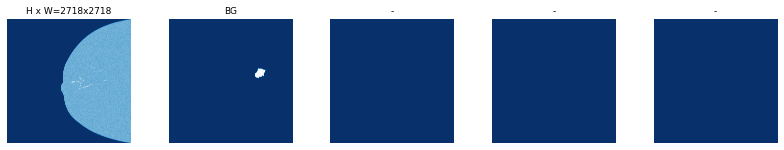

image Shape
(2718, 2718)
mask Shape
(2718, 2718, 1)
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  4478  5679  8355]
 [    0     0     0 ... 13543 15619 16929]
 ...
 [    0     0     0 ... 14690 15127 16165]
 [    0     0     0 ...  9393 11468 10594]
 [    0     0     0 ...  4369  4423  6225]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]] [1]


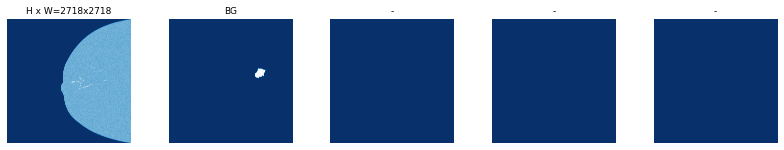

image Shape
(2718, 2718)
mask Shape
(2718, 2718, 1)
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  4478  5679  8355]
 [    0     0     0 ... 13543 15619 16929]
 ...
 [    0     0     0 ... 14690 15127 16165]
 [    0     0     0 ...  9393 11468 10594]
 [    0     0     0 ...  4369  4423  6225]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]] [1]


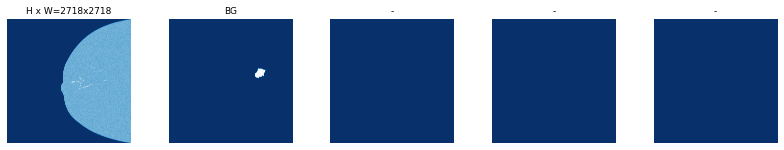

image Shape
(2718, 2718)
mask Shape
(2718, 2718, 1)
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  4478  5679  8355]
 [    0     0     0 ... 13543 15619 16929]
 ...
 [    0     0     0 ... 14690 15127 16165]
 [    0     0     0 ...  9393 11468 10594]
 [    0     0     0 ...  4369  4423  6225]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]] [1]


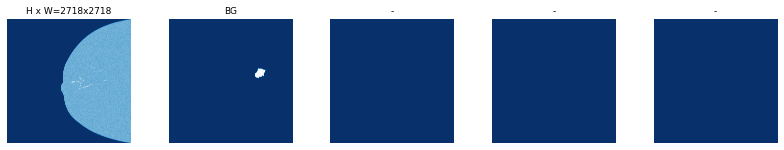

In [12]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)

for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)
    #print(dataset.class_names)
    visualize.display_top_masks(image, masks, image_id, dataset.class_names)

image Shape
(2718, 2718)
mask Shape
(2718, 2718, 1)
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  4478  5679  8355]
 [    0     0     0 ... 13543 15619 16929]
 ...
 [    0     0     0 ... 14690 15127 16165]
 [    0     0     0 ...  9393 11468 10594]
 [    0     0     0 ...  4369  4423  6225]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]] [1]


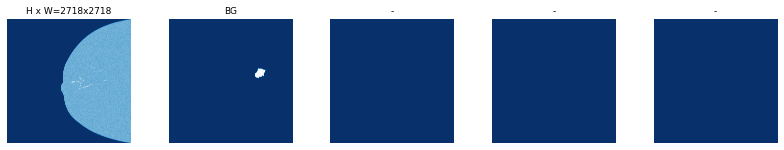

image Shape
(2718, 2718)
mask Shape
(2718, 2718, 1)
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  4478  5679  8355]
 [    0     0     0 ... 13543 15619 16929]
 ...
 [    0     0     0 ... 14690 15127 16165]
 [    0     0     0 ...  9393 11468 10594]
 [    0     0     0 ...  4369  4423  6225]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]] [1]


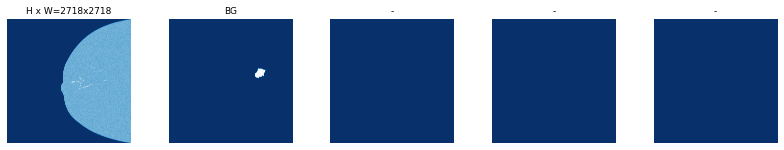

image Shape
(2718, 2718)
mask Shape
(2718, 2718, 1)
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  4478  5679  8355]
 [    0     0     0 ... 13543 15619 16929]
 ...
 [    0     0     0 ... 14690 15127 16165]
 [    0     0     0 ...  9393 11468 10594]
 [    0     0     0 ...  4369  4423  6225]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]] [1]


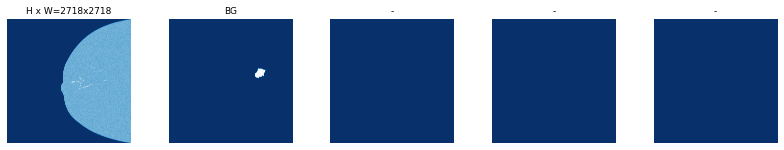

image Shape
(2718, 2718)
mask Shape
(2718, 2718, 1)
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  4478  5679  8355]
 [    0     0     0 ... 13543 15619 16929]
 ...
 [    0     0     0 ... 14690 15127 16165]
 [    0     0     0 ...  9393 11468 10594]
 [    0     0     0 ...  4369  4423  6225]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]] [1]


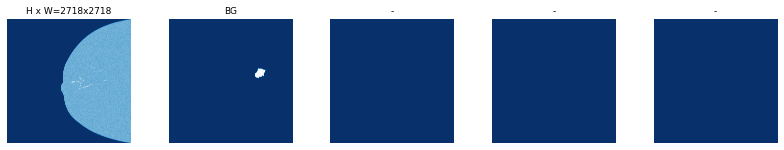

In [12]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)

for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)
    #print(dataset.class_names)
    visualize.display_top_masks(image, masks, image_id, dataset.class_names)